In [1]:
import PIL.Image

import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose

import cv2


from flygym.util.CPG_helpers import (advancement_transfer, phase_oscillator, sine_output, initialize_solver,
                         phase_biases_tripod_measured, phase_biases_tripod_idealized,
                         phase_biases_ltetrapod_idealized, phase_biases_metachronal_idealized,
                         plot_phase_amp_output)

In [2]:
# Initialize the simulation
run_time = 1
sim_params = MuJoCoParameters(timestep=1e-4, render_mode="headless", enable_adhesion=False, draw_adhesion=True)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
)

num_steps_base = int(run_time / nmf.timestep)

In [3]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
# Interpolate 5x
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [5]:
legs = ["RF", "RM", "RH", "LF", "LM", "LH"]
n_oscillators = len(legs)

t = np.arange(0, run_time, nmf.timestep)

n_joints = len(nmf.actuated_joints)
leg_ids = np.arange(len(legs)).astype(int)
joint_ids = np.arange(n_joints).astype(int)
# Map the id of the joint to the leg it belongs to (usefull to go through the steps for each legs)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])

In [6]:
# lets say we want 10 oscillations in the time period
n_steps = 12
frequencies = np.ones(n_oscillators) * n_steps / run_time

# For now each oscillator have the same amplitude
target_amplitudes = np.ones(n_oscillators) * 1.0
rates = np.ones(n_oscillators) * 20.0

phase_biases = phase_biases_tripod_idealized * 2 * np.pi
coupling_weights = (np.abs(phase_biases) > 0).astype(float) * 10.0 

In [7]:
n_stabilisation_steps = 2000
num_steps = n_stabilisation_steps + num_steps_base

# Initilize the simulation
np.random.seed(42)
start_ampl = np.ones(6)*0.2
obs, info = nmf.reset()
solver = initialize_solver(phase_oscillator, "dopri5", nmf.curr_time,
                            n_oscillators, frequencies,
                              coupling_weights, phase_biases,
                                start_ampl, rates,
                                int_params={"atol": 1e-6, "rtol": 1e-6, "max_step":100000})


# Initalize storage
obs_list_noadh = []

for i in trange(num_steps):

    res = solver.integrate(nmf.curr_time)
    phase = res[:n_oscillators]
    amp = res[n_oscillators:2*n_oscillators]
    if i == n_stabilisation_steps:
        # Now set the amplitude to their real values
        solver.set_f_params(n_oscillators, frequencies,
                              coupling_weights, phase_biases,
                                target_amplitudes, rates)
    if i > n_stabilisation_steps:
        indices = advancement_transfer(phase, interp_step_duration, match_leg_to_joints)
        # scale amplitude by interpolating between the resting values and i timestep value
        input_joint_angles = data_block[joint_ids, 0] + \
                  (data_block[joint_ids, indices]-data_block[joint_ids, 0])*amp[match_leg_to_joints]
    else:
        input_joint_angles = data_block[joint_ids, 0]

    adhesion = np.zeros(6)
    action = {"joints": input_joint_angles, "adhesion": adhesion}
    
    obs, reward, terminated, truncated, info = nmf.step(action)
    obs_list_noadh.append(obs)
    render_status = nmf.render()
  
if nmf.render_mode == "saved":
  no_adh_video_path = Path(f"CPG_adhesion/no_adh_flat.mp4")
  nmf.save_video(no_adh_video_path)


sim_params.enable_adhesion = True
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    )
solver = initialize_solver(phase_oscillator, "dopri5", nmf.curr_time,
                            n_oscillators, frequencies,
                              coupling_weights, phase_biases,
                                start_ampl, rates,
                                int_params={"atol": 1e-6, "rtol": 1e-6, "max_step":100000})
obs_list_adh = []
all_adhesions = []
for i in trange(num_steps):

    res = solver.integrate(nmf.curr_time)
    phase = res[:n_oscillators]
    amp = res[n_oscillators:2*n_oscillators]
    if i == n_stabilisation_steps:
        # Now set the amplitude to their real values
        solver.set_f_params(n_oscillators, frequencies,
                              coupling_weights, phase_biases,
                                target_amplitudes, rates)
    if i > n_stabilisation_steps:
        indices = advancement_transfer(phase, interp_step_duration, match_leg_to_joints)
        # scale amplitude by interpolating between the resting values and i timestep value
        input_joint_angles = data_block[joint_ids, 0] + \
                  (data_block[joint_ids, indices]-data_block[joint_ids, 0])*amp[match_leg_to_joints]
    else:
        input_joint_angles = data_block[joint_ids, 0]

    adhesion = nmf.get_adhesion_vector()
    all_adhesions.append(adhesion)
    action = {"joints": input_joint_angles, "adhesion": adhesion}
    
    obs, reward, terminated, truncated, info = nmf.step(action)
    obs_list_adh.append(obs)
    render_status = nmf.render()
  
if nmf.render_mode == "saved":
  adh_video_path = Path(f"CPG_adhesion/adh_flat.mp4")
  nmf.save_video(adh_video_path)

100%|██████████| 12000/12000 [00:26<00:00, 453.13it/s]


/var/folders/g_/c0_j6ct50dz58057rf7b3_s00000gq/T/ipykernel_65347/121989305.py:38: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax_noadh.get_shared_y_axes().join(ax_noadh, ax_adh)
/var/folders/g_/c0_j6ct50dz58057rf7b3_s00000gq/T/ipykernel_65347/121989305.py:39: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax_contact_noadh.get_shared_y_axes().join(ax_contact_noadh, ax_contact_adh)
/var/folders/g_/c0_j6ct50dz58057rf7b3_s00000gq/T/ipykernel_65347/121989305.py:40: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax_zpos_noadh.get_shared_y_axes().join(ax_zpos_noadh, ax_zpos_adh)


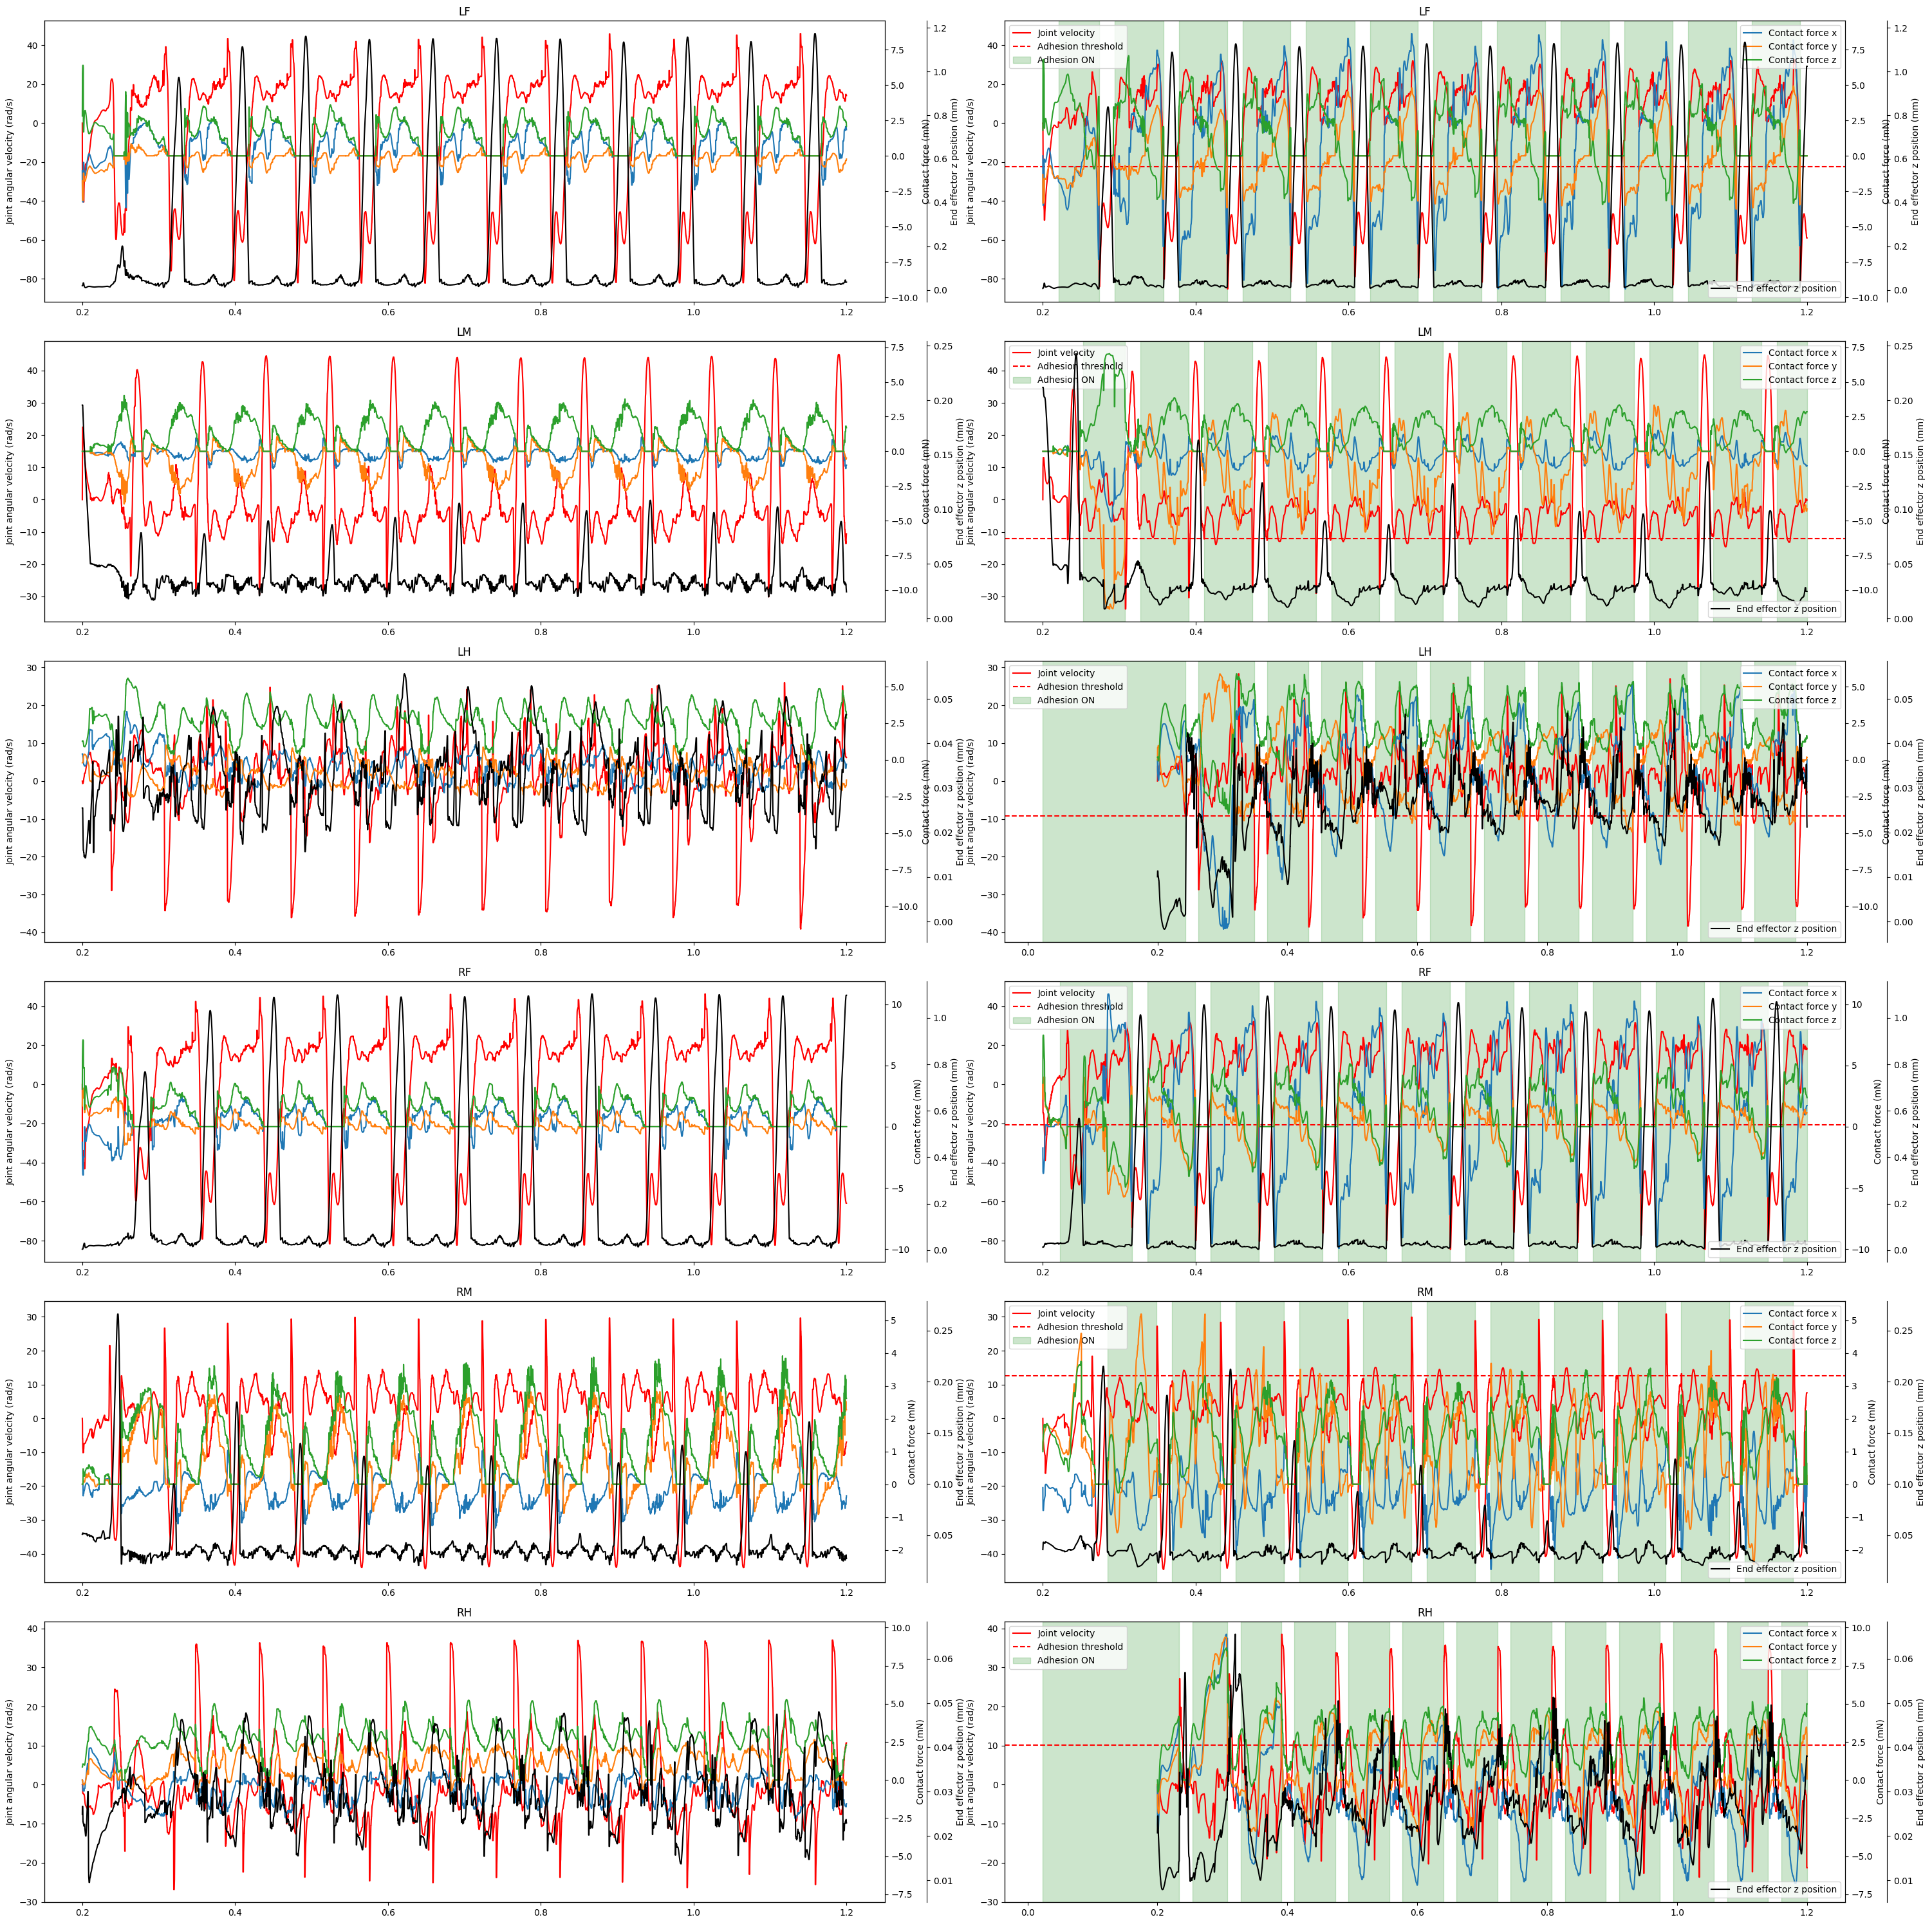

In [76]:
# make a figure with side by side plt with and without adhesion for each leg
import flygym.util.config as config
from scipy.signal import medfilt

tarsalsegordered_legs = [lts[:2] for lts in nmf.last_tarsalseg_names]
contact_sensors_in_legs = [[i for i, cs in enumerate(nmf.contact_sensor_placements) if l in cs] for l in tarsalsegordered_legs]
lts_to_ee = [i for l in tarsalsegordered_legs for i, ee in enumerate(nmf.end_effector_sensors) if l in ee.name]

joint_velocities_noadh = np.array([obs["joints"][1] for obs in obs_list_noadh])
joint_velocities_adh = np.array([obs["joints"][1] for obs in obs_list_adh])
contact_forces_noadh = np.array([obs["contact_forces"] for obs in obs_list_noadh])
contact_forces_adh = np.array([obs["contact_forces"] for obs in obs_list_adh])
end_effector_positions_noadh = np.array([obs["end_effectors"] for obs in obs_list_noadh])
end_effector_positions_adh = np.array([obs["end_effectors"] for obs in obs_list_adh])

all_adhesions = np.array(all_adhesions)

time = np.arange(num_steps)*nmf.sim_params.timestep

window = (11,)
preprocess = lambda x: medfilt(x, window)


fig, axs = plt.subplots(len(legs), 2, figsize=(30, 30))


for i, leg in enumerate(tarsalsegordered_legs):    
    ref_joint_id = nmf.leglift_ref_jnt_id[i]
    ref_joint_thr = config.adhesion_speed_thresholds[i]
    ref_joint_name = nmf.actuated_joints[ref_joint_id]
    
    ax_noadh = axs[i, 0]
    ax_adh = axs[i, 1]
    ax_contact_noadh = ax_noadh.twinx()
    ax_zpos_noadh = ax_noadh.twinx()
    ax_contact_adh = ax_adh.twinx()
    ax_zpos_adh = ax_adh.twinx()
    ax_noadh.get_shared_y_axes().join(ax_noadh, ax_adh)
    ax_contact_noadh.get_shared_y_axes().join(ax_contact_noadh, ax_contact_adh)
    ax_zpos_noadh.get_shared_y_axes().join(ax_zpos_noadh, ax_zpos_adh)

    ax_noadh.set_title(leg)
    ax_adh.set_title(leg)
    ax_noadh.set_ylabel("Joint angular velocity (rad/s)")
    ax_adh.set_ylabel("Joint angular velocity (rad/s)")
    ax_contact_noadh.set_ylabel("Contact force (mN)")
    ax_contact_adh.set_ylabel("Contact force (mN)")
    ax_zpos_noadh.set_ylabel("End effector z position (mm)")
    ax_zpos_adh.set_ylabel("End effector z position (mm)")
    ax_zpos_noadh.spines.right.set_position(("axes", 1.05))
    ax_zpos_adh.spines.right.set_position(("axes", 1.05))

    ax_noadh.plot(time[n_stabilisation_steps:], preprocess(joint_velocities_noadh[n_stabilisation_steps:, ref_joint_id]), label="Joint velocity", color="red")
    ax_adh.plot(time[n_stabilisation_steps:], preprocess(joint_velocities_adh[n_stabilisation_steps:, ref_joint_id]), label="Joint velocity", color="red")
    ax_adh.axhline(ref_joint_thr, color="red", linestyle="--", label="Adhesion threshold")

    contact_force_noadh = np.sum(contact_forces_noadh[n_stabilisation_steps:, :, contact_sensors_in_legs[i]], axis=-1)
    contact_force_adh = np.sum(contact_forces_adh[n_stabilisation_steps:, :, contact_sensors_in_legs[i]], axis=-1)

    for k, coord in enumerate(["x", "y", "z"]):
        ax_contact_noadh.plot(time[n_stabilisation_steps:], preprocess(contact_force_noadh[:, k]), label=f"Contact force {coord}")
        ax_contact_adh.plot(time[n_stabilisation_steps:], preprocess(contact_force_adh[:, k]), label=f"Contact force {coord}")

    i_ee = lts_to_ee[i]
    ax_zpos_noadh.plot(time[n_stabilisation_steps:], preprocess(end_effector_positions_noadh[n_stabilisation_steps:, i_ee*3 + 2]), label="End effector z position", color="black")
    ax_zpos_adh.plot(time[n_stabilisation_steps:], preprocess(end_effector_positions_adh[n_stabilisation_steps:, i_ee*3 + 2]), label="End effector z position", color="black")

    # Color adhesion periods in green
    adh_ids = np.where(all_adhesions[:, i] > 0)[0]
    adh_ids = np.split(adh_ids, np.where(np.diff(adh_ids) != 1)[0] + 1)
    #START AT ONE JUST TO HIDE STABILIZATION PHASE
    ax_adh.axvspan(time[adh_ids[1][0]], time[adh_ids[1][-1]], alpha=0.2, color="green", label="Adhesion ON")
    for adh_id in adh_ids[2:]:
        ax_adh.axvspan(time[adh_id[0]], time[adh_id[-1]], alpha=0.2, color="green")

    ax_adh.legend(loc ="upper left")
    ax_contact_adh.legend(loc="upper right")
    ax_zpos_adh.legend(loc ="lower right")

plt.tight_layout()

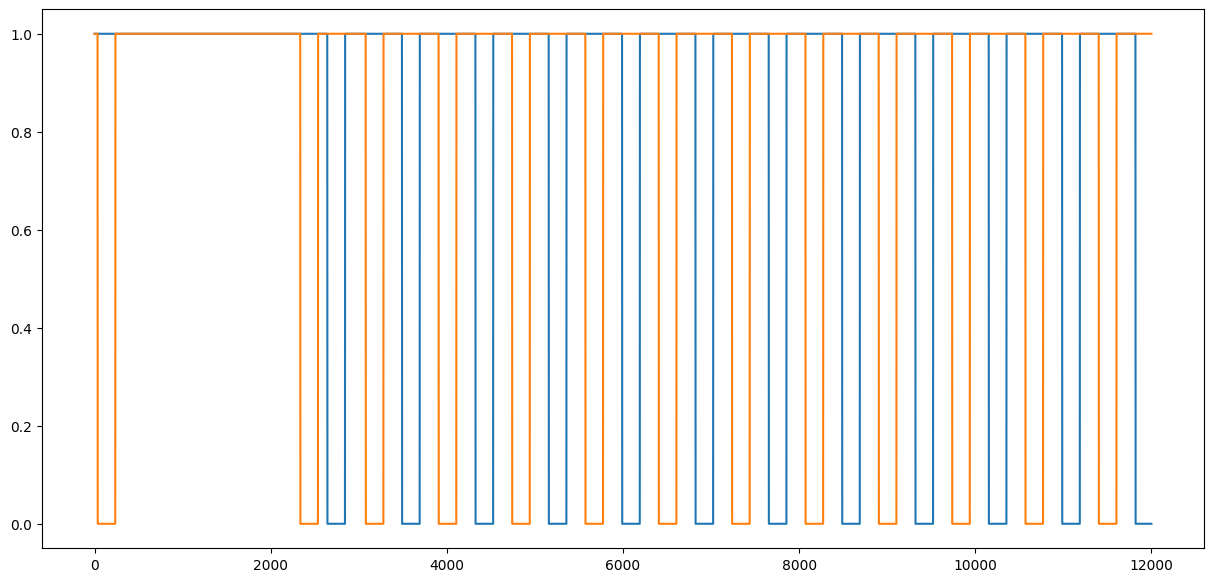

In [75]:
plt.figure(figsize=(15,7))
plt.plot(all_adhesions[:, [-2, -1]])